Starting data loading process (using essential columns and adjusted path)...
Dataset loaded successfully!
Initial shape: (9609797, 2)
                                             Product  \
0  Credit reporting or other personal consumer re...   
1                                    Debt collection   
2  Credit reporting or other personal consumer re...   
3  Credit reporting or other personal consumer re...   
4  Credit reporting or other personal consumer re...   

  Consumer complaint narrative  
0                          NaN  
1                          NaN  
2                          NaN  
3                          NaN  
4                          NaN  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9609797 entries, 0 to 9609796
Data columns (total 2 columns):
 #   Column                        Dtype 
---  ------                        ----- 
 0   Product                       object
 1   Consumer complaint narrative  object
dtypes: object(2)
memory usage: 146.6+ MB
Product  

C:\Users\josib\AppData\Local\Temp\ipykernel_4516\3316836957.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=product_counts.index, y=product_counts.values, palette='viridis')


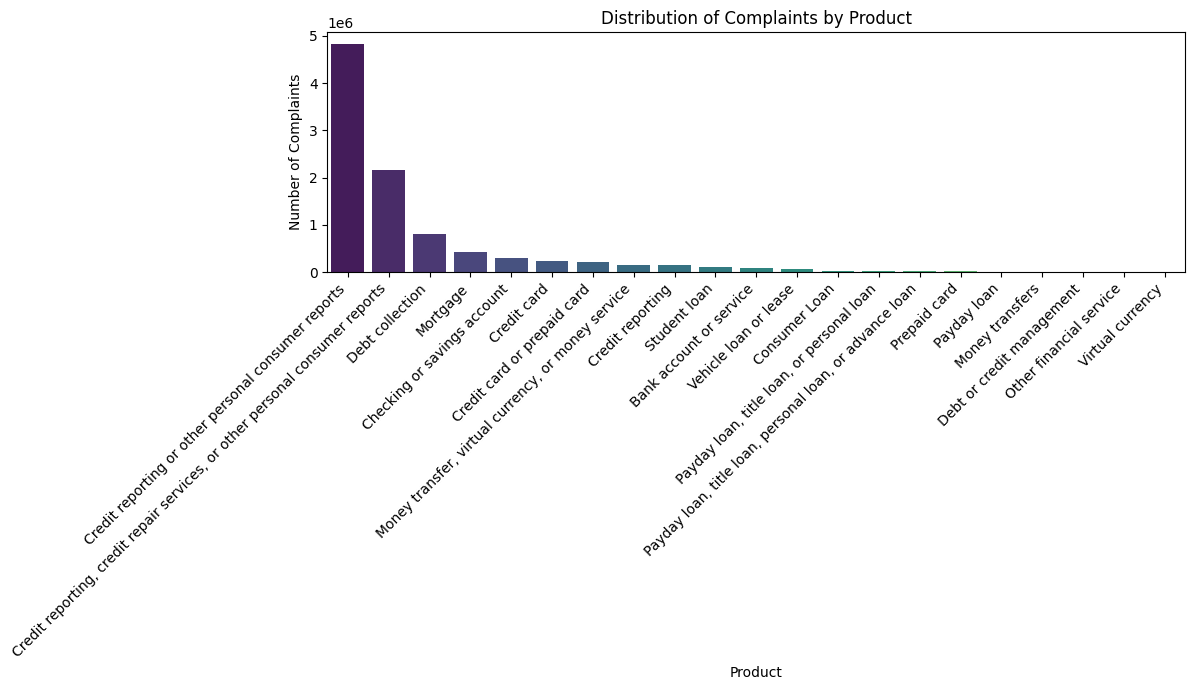

count    9.609797e+06
mean     5.515649e+01
std      1.495169e+02
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      5.000000e+01
max      6.469000e+03
Name: narrative_length, dtype: float64


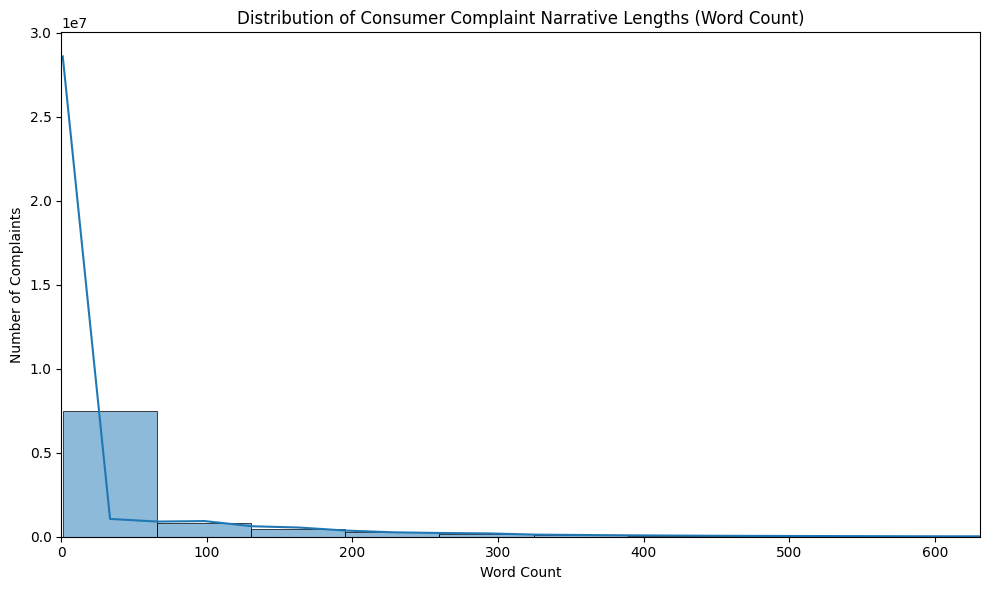

Number of complaints with narrative: 9609797
Number of complaints without narrative: 0
Total records: 9609797
(899940, 3)
['Credit card' 'Checking or savings account'
 'Money transfer, virtual currency, or money service'
 'Credit card or prepaid card' 'Payday loan, title loan, or personal loan']
Removed 455861 records with empty narratives.
(444079, 3)
                            Consumer complaint narrative  \
12237  A XXXX XXXX card was opened under my name by a...   
12532  I made the mistake of using my wellsfargo debi...   
13280  Dear CFPB, I have a secured credit card with c...   
13506  I have a Citi rewards cards. The credit balanc...   
13955  b'I am writing to dispute the following charge...   

                                       cleaned_narrative  
12237  a xxxx xxxx card was opened under my name by a...  
12532  i made the mistake of using my wellsfargo debi...  
13280  dear cfpb i have a secured credit card with ci...  
13506  i have a citi rewards cards the credit ba

OSError: Cannot save file into a non-existent directory: 'data'

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

print("Starting data loading process (using essential columns and adjusted path)...")

try:
    raw_df = pd.read_csv(
        '../data/complaints.csv',
        low_memory=False,
        usecols=['Product', 'Consumer complaint narrative']
    )
    print("Dataset loaded successfully!")
    print(f"Initial shape: {raw_df.shape}")
    print(raw_df.head())
except FileNotFoundError:
    print("Error: 'complaints.csv' not found. Please ensure it's in the 'data/' directory within your project root.")
except Exception as e:
    print(f"An error occurred while loading the dataset: {e}")

if 'raw_df' in locals() and raw_df is not None:
    df = raw_df.copy()

    df.info()
    print(df.isnull().sum())
    print(df.describe(include='all'))

    product_counts = df['Product'].value_counts()
    print(product_counts)

    plt.figure(figsize=(12, 7))
    sns.barplot(x=product_counts.index, y=product_counts.values, palette='viridis')
    plt.title('Distribution of Complaints by Product')
    plt.xlabel('Product')
    plt.ylabel('Number of Complaints')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    df['Consumer complaint narrative'] = df['Consumer complaint narrative'].astype(str).fillna('')
    df['narrative_length'] = df['Consumer complaint narrative'].apply(lambda x: len(x.split()))

    print(df['narrative_length'].describe())

    plt.figure(figsize=(10, 6))
    sns.histplot(df['narrative_length'], bins=100, kde=True)
    plt.title('Distribution of Consumer Complaint Narrative Lengths (Word Count)')
    plt.xlabel('Word Count')
    plt.ylabel('Number of Complaints')
    plt.xlim(0, df['narrative_length'].quantile(0.99))
    plt.tight_layout()
    plt.show()

    num_with_narrative = df[df['narrative_length'] > 0].shape[0]
    num_without_narrative = df[df['narrative_length'] == 0].shape[0]
    print(f"Number of complaints with narrative: {num_with_narrative}")
    print(f"Number of complaints without narrative: {num_without_narrative}")
    print(f"Total records: {df.shape[0]}")

    allowed_products = [
        'Credit card',
        'Personal loan',
        'Buy Now, Pay Later (BNPL)',
        'Savings account',
        'Money transfer'
    ]

    product_mapping_candidates = {
        'Credit card': ['Credit card', 'Credit card or prepaid card'],
        'Personal loan': ['Personal loan', 'Payday loan, title loan, or personal loan', 'Consumer loan'],
        'Buy Now, Pay Later (BNPL)': ['Consumer loan'],
        'Savings account': ['Checking or savings account', 'Savings account'],
        'Money transfer': ['Money transfer, virtual currency, or money service', 'Money transfer']
    }

    target_products_in_data = []
    for challenge_product in allowed_products:
        if challenge_product in product_mapping_candidates:
            target_products_in_data.extend(product_mapping_candidates[challenge_product])
        else:
            target_products_in_data.append(challenge_product)

    df_filtered = df[df['Product'].isin(target_products_in_data)].copy()
    print(df_filtered.shape)
    print(df_filtered['Product'].unique())

    initial_rows = df_filtered.shape[0]
    df_filtered = df_filtered[df_filtered['Consumer complaint narrative'].str.strip() != '']
    df_filtered = df_filtered[df_filtered['Consumer complaint narrative'].str.lower() != 'nan']
    rows_after_narrative_filter = df_filtered.shape[0]
    print(f"Removed {initial_rows - rows_after_narrative_filter} records with empty narratives.")
    print(df_filtered.shape)

    def clean_narrative_text(text):
        text = str(text).lower()
        boilerplate_phrases = [
            "i am writing to file a complaint",
            "i am writing this letter to",
            "to whom it may concern",
            "my complaint is regarding",
            "this is a complaint about"
        ]
        for phrase in boilerplate_phrases:
            text = text.replace(phrase, "")
        text = re.sub(r'[^a-z\s]', '', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text

    df_filtered['cleaned_narrative'] = df_filtered['Consumer complaint narrative'].apply(clean_narrative_text)

    print(df_filtered[['Consumer complaint narrative', 'cleaned_narrative']].head())

    output_path = '../data/filtered_complaints.csv'
    df_filtered.to_csv(output_path, index=False)
    print(f"Cleaned and filtered dataset saved to: {output_path}")
else:
    print("Dataframe was not loaded. Cannot proceed with processing.")